**Normalizing Flows** (NF)

made by: Anas Aldadi from scratch (uhm using torch and numpy nothing more)

The third generative modelling in this coding tutorials is normalizing flows.

While diffusion models give us the power to generate data when having a noise scheduler, normalizing flow are a set of generative models that unlocks the power generating data by finding the change of random variables.

<img src="https://drive.google.com/uc?id=18C5x9BdKR-J27UWNWCjUQEk1SprE7XdM" width="1000">

this set of generative models have many types:

* Coupling Layers (Affine Coupling and Additive Coupling): These are a key building block in many modern normalizing flows (like Real NVP and Glow). They work by splitting the input dimensions and applying a transformation to one part conditioned on the other part.

* Invertible 1x1 Convolutions: Used in models like Glow, these are linear transformations that are still invertible and help in mixing the channels of the data.

* Continuous Normalizing Flows (CNFs): Instead of a discrete sequence of layers, CNFs define the transformation as a continuous-time differential equation. This leads to different training and evaluation dynamics.

and so much more than those btw!

in this tutorial i'm gonna build a vanilla NF from the original paper, to make the archeticture as clear and simple as possible

**Resources used to make this notebook:**

https://arxiv.org/pdf/1505.05770v6 also see: https://paperswithcode.com/method/normalizing-flows


<img src="https://drive.google.com/uc?id=1JCv39qNSFZvWVoRq4csF_VzxBGzz5tUL" width="1000">

At its core, a normalizing flow aims to transform a simple, known probability distribution (like a standard Gaussian) into a complex, unknown target distribution (often the distribution of your data) through a sequence of invertible and differentiable transformations. [ref](https://paperswithcode.com/method/normalizing-flows)

so inferring from this we will build transformation layers and their inverses!!

A "vanilla" normalizing flow typically refers to a simple flow constructed by stacking one or more basic invertible transformations. The key is that each transformation in the sequence must have a tractable inverse and a tractable determinant of its Jacobian.

~btw i apologize for the bad quality of the image but i couldn't render LaTeX on colab's text cell so i had to screenshot it :(




---


<img src="https://drive.google.com/uc?id=1HypCRb-vYC8xdmG5Ij2lH0brQLWHjDhu" width="1000">

The final output z_k=z is a point in the latent space, which should follow a simple distribution (e.g., a standard Gaussian). During training, the parameters of the transformations are learned such that the distribution of these transformed data points matches the chosen base distribution.



---

<img src="https://drive.google.com/uc?id=1_zn4ePyCw151ahV08hqpmmdtWAhWxbbQ" width="1000">

**In essence:**

* Forward: Maps data to a simple latent space and allows for density estimation.
* Backward: Maps samples from the simple latent space back to the complex data space, enabling generation.

[ref](https://colab.research.google.com/github/whitead/dmol-book/blob/master/dl/flows.ipynb)

good references:
* [Learning distributions on compact support using Normalizing Flows](https://selflein.github.io/normalizing_flow_bounded_domain)
* [On the Universality of Volume-Preserving and Coupling-Based Normalizing Flows](https://arxiv.org/html/2402.06578v2)

## Reqs

In [ ]:
import gdown
folder_id = "1ywizLmoqZj_iOA0xFx3y1cJykFlbgkOu"
gdown.download_folder(f"https://drive.google.com/drive/folders/{folder_id}", quiet=False, use_cookies=False)

Retrieving folder contents


Processing file 18C5x9BdKR-J27UWNWCjUQEk1SprE7XdM comparison_GAN_VAE_NF.png
Processing file 1n_PdjTcMVnyoC6pJO3HoTr_uiKzSk2AR important1.png
Processing file 1bUBwJWGdXLR58a18IGRzy0Aok-BbCRl9 important2.png
Processing file 1Sect82BB-UQtG55rsxnDB7nMs15VC-ED important3.png
Processing file 15OR65HGg9zG74v8AywXJ_7OXHXfwVFdF nf.png
Processing file 1-7FoHp4T06MgKy_O3ZLxO-t7Ton3u3J4 simple_flow_161_loss.pth
Processing file 1XVPslA5XkddRwJ8zFcZganlAO0GQJfdR simple_flow.pth


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=18C5x9BdKR-J27UWNWCjUQEk1SprE7XdM
To: /content/normalizing_flow/comparison_GAN_VAE_NF.png
100%|██████████| 255k/255k [00:00<00:00, 18.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1n_PdjTcMVnyoC6pJO3HoTr_uiKzSk2AR
To: /content/normalizing_flow/important1.png
100%|██████████| 93.7k/93.7k [00:00<00:00, 7.88MB/s]
Downloading...
From: https://drive.google.com/uc?id=1bUBwJWGdXLR58a18IGRzy0Aok-BbCRl9
To: /content/normalizing_flow/important2.png
100%|██████████| 172k/172k [00:00<00:00, 14.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Sect82BB-UQtG55rsxnDB7nMs15VC-ED
To: /content/normalizing_flow/important3.png
100%|██████████| 163k/163k [00:00<00:00, 16.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=15OR65HGg9zG74v8AywXJ_7OXHXfwVFdF
To: /content/normalizing_flow/nf.png
100%|██████████| 135k/135k [00:

['/content/normalizing_flow/comparison_GAN_VAE_NF.png',
 '/content/normalizing_flow/important1.png',
 '/content/normalizing_flow/important2.png',
 '/content/normalizing_flow/important3.png',
 '/content/normalizing_flow/nf.png',
 '/content/normalizing_flow/simple_flow_161_loss.pth',
 '/content/normalizing_flow/simple_flow.pth']

In [ ]:
import torch, torchvision

# torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

# Torchvision
from torchvision.datasets import MNIST
from torchvision import transforms as T

# Others
import glob, re, shutil, os, gc
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tqdm import tqdm

In [ ]:
print(device:='cuda' if torch.cuda.is_available() else 'cpu')

cpu


## Helpers

In [ ]:
def generate_intermediate_transformations(model, dataloader, device, num_images=4):
    """
    Returns:
        images: Tensor of original images [num_images, 1, 28, 28]
        forward_images: List of tensors at each forward step [step][num_images, 1, 28, 28]
        latent_images: Tensor of sampled latent vectors [num_images, 1, 28, 28]
        backward_images: List of tensors at each backward step [step][num_images, 1, 28, 28]
    """
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            images = batch.to(device)[:num_images]
            batch_size = images.size(0)
            x = images.view(batch_size, -1).float()

            # Forward pass
            forward_images = [x.view(batch_size, 1, 28, 28).cpu()]
            current_z = x
            for transform in model.transforms:
                current_z = transform.inverse(current_z)
                forward_images.append(current_z.view(batch_size, 1, 28, 28).cpu())

            # Latent sample
            # latent_z = torch.randn(batch_size, model.transforms[0].log_scale.shape[0], device=device) # uncomment if you are using logged affine transfromations
            latent_z = torch.randn(batch_size, model.transforms[0].weights.shape[0], device=device) # uncomment this if you are using normal affine transformations
            latent_images = latent_z.view(batch_size, 1, 28, 28).cpu()

            # Backward pass
            backward_images = [latent_images]
            current_x = latent_z
            for transform in reversed(model.transforms):
                current_x = transform(current_x)
                backward_images.append(current_x.view(batch_size, 1, 28, 28).cpu())

            return (
                images.view(batch_size, 1, 28, 28).cpu(),
                forward_images,
                latent_images,
                backward_images
            )

In [ ]:
def plot_image_grid(image_list, title_prefix="Step"):
    num_steps = len(image_list)
    num_images = image_list[0].shape[0]
    fig, axes = plt.subplots(num_steps, num_images, figsize=(8, 3 * num_steps))

    if num_images == 1:
        axes = axes[:, np.newaxis]
    elif num_steps == 1:
        axes = axes[np.newaxis, :]

    for i in range(num_steps):
        for j in range(num_images):
            axes[i, j].imshow(image_list[i][j].squeeze(), cmap='gray')
            axes[i, j].axis('off')
        axes[i, 0].set_ylabel(f"{title_prefix} {i}", fontsize=12)

In [ ]:
def flush_gpu(device=None, verbose=True):
    if not torch.cuda.is_available():
        if verbose:
            print("CUDA is not available.")
        return

    device = device or torch.cuda.current_device()
    torch.cuda.synchronize(device)

    if verbose:
        allocated = torch.cuda.memory_allocated(device) / (1024 ** 2)
        reserved = torch.cuda.memory_reserved(device) / (1024 ** 2)
        print(f"[Before] Allocated: {allocated:.2f} MB | Reserved: {reserved:.2f} MB")

    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

    if verbose:
        allocated = torch.cuda.memory_allocated(device) / (1024 ** 2)
        reserved = torch.cuda.memory_reserved(device) / (1024 ** 2)
        print(f"[After]  Allocated: {allocated:.2f} MB | Reserved: {reserved:.2f} MB")

In [ ]:
def preprocess_img(img):
    return img.cpu().permute(1,2,0)
def show(img):
    img = preprocess_img(img)
    plt.imshow(img)
    plt.axis('off')

## Data

normal data preperation you can ignore it.

The only important takeaway here is that i discretized MNIST which means the values of the image are in integers not continuous.

In [ ]:
class MNISTSegment(Dataset):

    def __init__(self, root, train=True, transform=None, download=True):
        super().__init__()
        self.dataset = MNIST(
            root=root,
            train=train,
            transform=transform,
            download=download
        )

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        image = (image * 255).int()
        return image

In [ ]:
print(os.cpu_count())

2


In [ ]:
size=28
transforme = T.Compose([
    T.ToTensor(),
    T.Resize((size, size)),
])

dataset = MNISTSegment(root="./data", train=True, transform=transforme)
train_dl = DataLoader(dataset, batch_size=30000, shuffle=True, pin_memory=True, num_workers=2)

In [ ]:
for images in train_dl:
    print(images.shape)
    break

torch.Size([1024, 1, 28, 28])


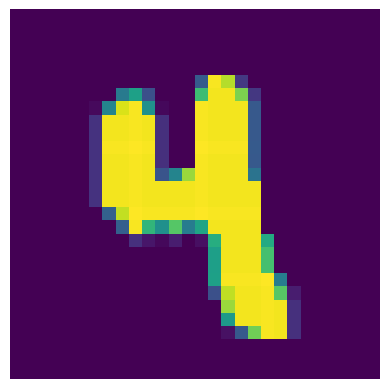

In [ ]:
show(images[0])

## loss func

we will start by defining the loss function! the negative log likelihood of normalizing flows

<img src="https://drive.google.com/uc?id=1DivKevc-nWMvsDnZmLS7OxKEtX_a_tRT" width="1000">

In [ ]:
latent_dim = size * size

def log_prob_base(z):
    """
    D-dimentional standard normal distribution where D is latent_dim flattened size of MNIST
    """
    log_p = -.5 * torch.sum(z**2,dim=1) - .5 * latent_dim * np.log(2 * np.pi)
    return log_p

In [ ]:
batch_size = 64
dummy_z = torch.randn(batch_size, latent_dim)
log_probs = log_prob_base(dummy_z)
print(f"shape of dummy latent variables: {dummy_z.shape}")
print(f"shape of log probabilities: {log_probs.shape}")
print(f"log probabilities for the first 5 samples:\n{log_probs[:5]}")

shape of dummy latent variables: torch.Size([64, 784])
shape of log probabilities: torch.Size([64])
log probabilities for the first 5 samples:
tensor([-1087.0530, -1120.1504, -1104.6099, -1152.6257, -1128.1411])


### Invertable transformations

In [ ]:
#@title ignore this :3
class LoggedAffineTransformation(nn.Module):
    ### This is logged to have positive weights (faster convergence in training yippie! but will cease to converge way earlier than the normal transformations bummer)
    def __init__(self, input_dim):
        super().__init__()
        #log-parameterization for stability and positivity
        self.log_scale = nn.Parameter(torch.randn(input_dim))
        self.bias = nn.Parameter(torch.zeros(input_dim))

    def forward(self, z):
        scale = torch.exp(self.log_scale)
        return z * scale + self.bias

    def inverse(self, x):
        scale = torch.exp(self.log_scale)
        return (x - self.bias) / scale

    def log_det_jacobian(self, z):
        ldj = torch.sum(self.log_scale)
        return ldj.expand(z.shape[0])

Now we define our transformation for the forward and write its inverse!

i chose the simplest ever transformation **"z = W @ x + b"** pretty neat right?! :O

its inverse is not that hard either **"x = (z-b)/W"**

since the chosen transformation is so simple, we'll face a problem during the training which is that the generation will be so bad, and the loss function will start with a very large number even though we are training on MNIST!.

An affine transformation is a mathematical operation that transforms geometric objects while preserving points, straight lines, and planes. It combines linear transformations, such as rotation and scaling, with translations, allowing the manipulation of objects in space without altering their fundamental structure. This transformation is particularly important in computer graphics and image processing, where it is used to manage how images are manipulated and displayed. [ref](https://library.fiveable.me/key-terms/introduction-engineering/affine-transformation)

In [ ]:
class AffineTransformation(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(input_dim))
        self.bias = nn.Parameter(torch.randn(input_dim))

    def forward(self, z):
        """
        Forward pass: transforms z to x.
        x = weight * z + bias
        """
        #print(f'z device is {z.device}, weights is {self.weights.device}')
        x = self.weights * z + self.bias
        return x

    def inverse(self,x):
        """
        inverse pass: transforms x back to z.
        z = (x - bias) / weight
        """
        z = (x - self.bias)/self.weights
        return z

    def log_det_jacobian(self, z):
        """
        calculates the log determinant of the Jacobian of the forward transformation.
        For an affine transformation x = w * z + b, the Jacobian is a diagonal
        matrix with 'w' on the diagonal. The determinant is the product of 'w',
        and the log determinant is the sum of log absolute values of 'w'.
        """
        ldj = torch.sum(torch.log(torch.abs(self.weights))) # ldj = log det jacobian. fyi
        # We need to return a tensor of the same batch size as the input
        #print(f'device is {z.device}')
        return torch.ones(z.shape[0], device=z.device) * ldj

In [ ]:
affine_transform = AffineTransformation(latent_dim).to(device)

In [ ]:
batch_size = 64
dummy_z = torch.randn(batch_size, latent_dim)
dummy_z = dummy_z.to(device)
transformed_x = affine_transform(dummy_z)
reconstructed_z = affine_transform.inverse(transformed_x)

print(f"shape of dummy latent variables (z): {dummy_z.shape}")
print(f"shape of transformed variables (x): {transformed_x.shape}")
print(f"shape of reconstructed latent variables (z_recon): {reconstructed_z.shape}")
print(f"are z and z_recon close? {torch.allclose(dummy_z.cpu(), reconstructed_z.cpu(), rtol=1e-5, atol=1e-8)}") #although this prints false but it doesn't matter the difference between the original and the reconstruction is negligible

# Let's also test the log determinant of the Jacobian
log_det_j = affine_transform.log_det_jacobian(dummy_z)
print(f"shape of log determinant of jacobian: {log_det_j.shape}")
print(f"log determinant of jacobian for the batch:\n{log_det_j}")

shape of dummy latent variables (z): torch.Size([64, 784])
shape of transformed variables (x): torch.Size([64, 784])
shape of reconstructed latent variables (z_recon): torch.Size([64, 784])
are z and z_recon close? False
shape of log determinant of jacobian: torch.Size([64])
log determinant of jacobian for the batch:
tensor([-476.7071, -476.7071, -476.7071, -476.7071, -476.7071, -476.7071,
        -476.7071, -476.7071, -476.7071, -476.7071, -476.7071, -476.7071,
        -476.7071, -476.7071, -476.7071, -476.7071, -476.7071, -476.7071,
        -476.7071, -476.7071, -476.7071, -476.7071, -476.7071, -476.7071,
        -476.7071, -476.7071, -476.7071, -476.7071, -476.7071, -476.7071,
        -476.7071, -476.7071, -476.7071, -476.7071, -476.7071, -476.7071,
        -476.7071, -476.7071, -476.7071, -476.7071, -476.7071, -476.7071,
        -476.7071, -476.7071, -476.7071, -476.7071, -476.7071, -476.7071,
        -476.7071, -476.7071, -476.7071, -476.7071, -476.7071, -476.7071,
        -476.70

In [ ]:
dummy_z.shape, reconstructed_z.shape

(torch.Size([64, 784]), torch.Size([64, 784]))

In [ ]:
np.isclose(dummy_z.detach().cpu().numpy(), reconstructed_z.detach().cpu().numpy())

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [ ]:
flush_gpu()

[Before] Allocated: 2.12 MB | Reserved: 4.00 MB
[After]  Allocated: 2.12 MB | Reserved: 4.00 MB


## Model

should be VanillaFlow the naming here is just for fun

In [ ]:
class VanillaChocolateFlow(nn.Module):
    def __init__(self, num_layers, input_dim):
        super().__init__()
        self.transforms = nn.ModuleList([
            AffineTransformation(input_dim) for _ in range(num_layers)
        ])

    def forward(self, x):
        """
        Forward pass: transforms data x through the sequence of transformations to get z.
        Also calculates the log determinant of the Jacobian of the entire forward pass.
        """
        ldj = torch.zeros(x.shape[0], device=x.device)
        z = x
        for transform in self.transforms:
            z = transform.inverse(z) # Note: We apply the inverse to go from data to latent
            ldj += transform.log_det_jacobian(z) # jacobian of the inverse
        return z, ldj

    def backward(self, z):
        """
        backward process (sampling not backpropagation): transforms latent z back to data x.
        """
        x=z
        for transform in reversed(self.transforms):
            x = transform(x) # subtle reminder the forward here don't be confused fella learner :)
        return x

In [ ]:
# the number of layers in our simple flow
num_layers = 1

# the flow model
simple_flow = VanillaChocolateFlow(num_layers, latent_dim).to(device)

In [ ]:
#testing the forward pass
batch_size = 64
dummy_x = torch.randn(batch_size, latent_dim)
latent_z, log_det_j_forward = simple_flow(dummy_x.to(device))

print(f"shape of input data (x): {dummy_x.shape}")
print(f"shape of latent variable (z): {latent_z.shape}")
print(f"shape of log determinant of jacobian (forward): {log_det_j_forward.shape}")

#testing the backward pass (sampling)
dummy_z_sample = torch.randn(batch_size, latent_dim) # sample from the base distribution
generated_x = simple_flow.backward(dummy_z_sample.to(device))
print(f"shape of generated data (x): {generated_x.shape}")

shape of input data (x): torch.Size([64, 784])
shape of latent variable (z): torch.Size([64, 784])
shape of log determinant of jacobian (forward): torch.Size([64])
shape of generated data (x): torch.Size([64, 784])


In [ ]:
img = next(iter(train_dl))

In [ ]:
img.shape

torch.Size([30000, 1, 28, 28])

In [ ]:
one_img = img[0].unsqueeze(0)     # shape: [1, 1, 28, 28]

# Step 2: Flatten and move to device
x = one_img.view(1, -1).float().to(device)  # shape: [1, 784]

# Step 3: Encode (forward pass through flow)
latent_z, log_det_j = simple_flow(x)

# Step 4: Decode (backward pass through flow)
reconstructed_x = simple_flow.backward(latent_z)

# Step 5: Reshape for visualization
reconstructed_img = reconstructed_x.view(1, 1, 28, 28).cpu()

# Original image for comparison
original_img = one_img.cpu()

In [ ]:
# reshape flat vector to image shape (batch, channels, height, width)
generated_x_image = generated_x.view(batch_size, 1, 28, 28)
dummy_x_image = dummy_x.view(batch_size, 1, 28, 28)

In [ ]:
reconstructed_img.shape

torch.Size([1, 1, 28, 28])

identical reconstructed images means the model is working as intended! it forward and backwarded perfectly.

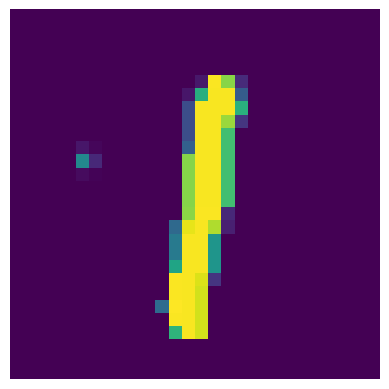

In [ ]:
show(original_img[0])

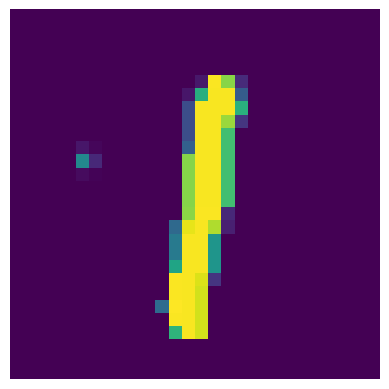

In [ ]:
show(reconstructed_img.detach()[0])

but generating from a base distribution is bad because the model is untrained

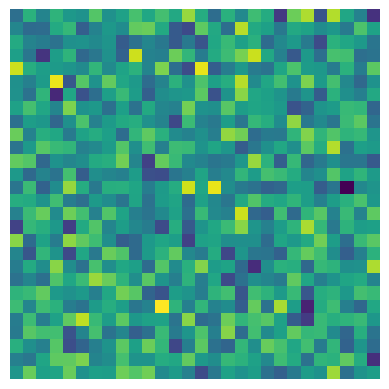

In [ ]:
show(dummy_x_image[0])

poor generation as you can see. don't get frustrated cuz its gonna persists being bad even after training lol

as i stated before this is stemming from the simplicity of the transformation

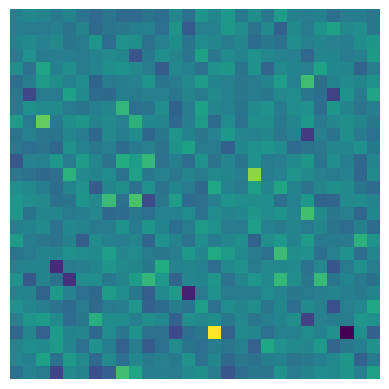

In [ ]:
show(generated_x_image[0].detach())

## Training!

In [ ]:
num_layers = 2

In [ ]:
simple_flow = VanillaChocolateFlow(num_layers, latent_dim).to(device)

In [ ]:
lr=1
optimizer = torch.optim.Adam(simple_flow.parameters(), lr=lr)

In [ ]:
epochs = 5

In [ ]:
for epoch in range(epochs):
    simple_flow.train()
    total_loss = 0
    for batch_idx, images in enumerate(train_dl):
        # Flatten the images
        batch_size = images.size(0)
        x = images.to(device, non_blocking=True).view(batch_size, -1).float() # Ensure float for calculations

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        z, log_det_j = simple_flow(x)

        # Calculate the log-likelihood
        log_likelihood = log_prob_base(z) + log_det_j

        # Calculate the negative log-likelihood loss
        loss = -torch.mean(log_likelihood)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * batch_size

        if (batch_idx + 1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Batch [{batch_idx+1}/{len(train_dl)}], Loss: {loss.item():.4f}")

    avg_loss = total_loss / len(train_dl.dataset)
    print(f"Epoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.4f}")
    flush_gpu(verbose=False)

print("Training finished!")

Epoch [1/5], Average Loss: 14202304682514.5332
Epoch [2/5], Average Loss: 66303.1367
Epoch [3/5], Average Loss: 16394.3223
Epoch [4/5], Average Loss: 6892.3174
Epoch [5/5], Average Loss: 3437.5519
Training finished!


14202304682514.5332 as you can see the first epoch is in bajillions this tells you that vanilla normalizing flow is one of the few cases in the world of statistical learning where you can have a big learning rate!!!!!!

### Saving and loading here

saving

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
model_path = "/content/normalizing_flow/simple_flow_experimental.pth"
torch.save({
    'model_state_dict': simple_flow.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}, model_path)

loading

In [ ]:
model = VanillaChocolateFlow(num_layers=2, input_dim=28*28).to(device)
optim = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
checkpoint = torch.load("/content/normalizing_flow/simple_flow_161_loss.pth", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
optim.load_state_dict(checkpoint['optimizer_state_dict'])

## Inference and seeing the generation through the layers

In [ ]:
# generate images
original_images, forward_steps, latent_images, backward_steps = generate_intermediate_transformations(
    model=model,
    dataloader=train_dl,
    device=device,
    num_images=2
)

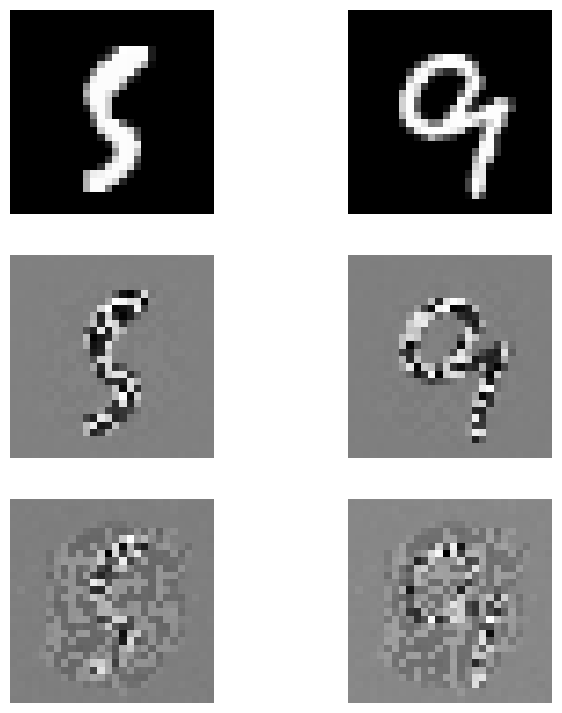

In [ ]:
plot_image_grid(forward_steps, title_prefix="forward")

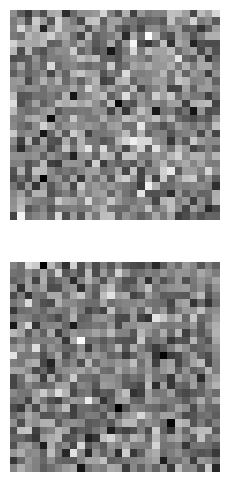

In [ ]:
plot_image_grid(latent_images, title_prefix="latent")

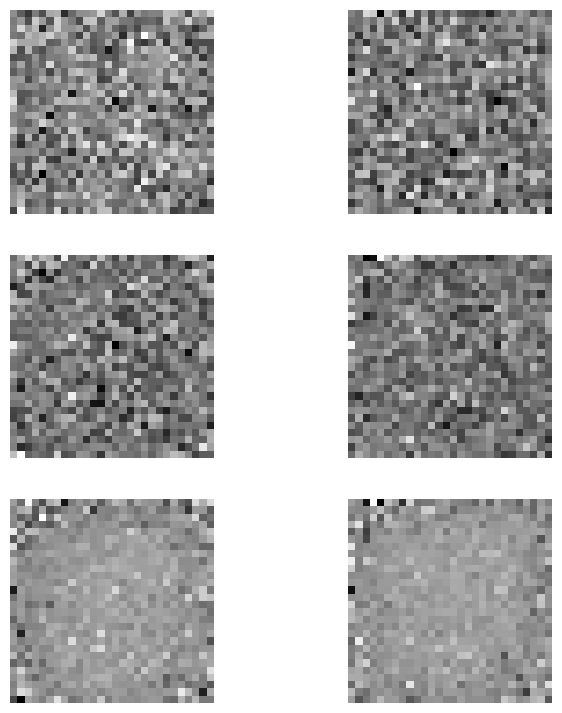

In [ ]:
plot_image_grid(backward_steps, title_prefix="backward")

generation from the base distribution

(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

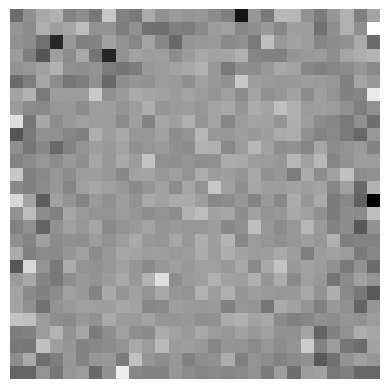

In [ ]:
z_sample = torch.randn(1, 784).to(device)
generated_x = model.backward(z_sample)
plt.imshow(generated_x.view(28, 28).cpu().detach(), cmap='gray')
plt.axis('off')